# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



### Age of the candidates grouped by parties.

In [4]:
import pandas as pd
from collections import defaultdict

df = pd.read_excel("alldata.xlsx")

#We exclude them who have not provide an age.
dff = df[df["alder"] > 0]
age_by_party = dff.groupby("parti")["alder"].describe()

print(age_by_party)

                                             count       mean        std  \
parti                                                                      
Alternativet                                  65.0  47.415385  13.620862   
Danmarksdemokraterne                          37.0  51.216216  10.252737   
Dansk Folkeparti                              49.0  45.530612  12.191360   
Det Konservative Folkeparti                   94.0  44.723404  11.904101   
Enhedslisten                                  71.0  42.225352  15.193229   
Frie Grønne, Danmarks Nye Venstrefløjsparti   26.0  34.807692  10.777826   
Kristendemokraterne                           41.0  50.219512  13.441563   
Liberal Alliance                              68.0  37.970588  13.736291   
Løsgænger                                      3.0  48.000000   9.165151   
Moderaterne                                   42.0  44.261905  13.778845   
Nye Borgerlige                                50.0  48.520000  12.241182   
Radikale Ven

- Count = how many.
- Mean = average.
- Std (Standard deviation) = average amount deviating from the mean.

- 25% and 75% have an age below that value.
- 50% = median.

### An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.

In [5]:
df_filtered = df.drop(columns=["alder"])

def calculate_confidence(row):
    # Identify The amount of questions, to get the confidence proportion in later calculation.
    valid_responses = [value for value in row if isinstance(value, int) and -2 <= value <= 2]
    
    # Count the "strongly agree" (2) and "strongly disagree" (-2) responses
    confident_responses = sum(1 for r in valid_responses if r == 2 or r == -2)
    
    proportion = confident_responses / len(valid_responses)
    return proportion

# Apply the function to each row (candidate)
df_filtered["confidence_proportion"] = df_filtered.apply(calculate_confidence, axis=1)

df_sorted = df_filtered.sort_values(by="confidence_proportion", ascending=False)

print(df_sorted[["navn", "parti", "confidence_proportion"]])

                     navn                                        parti  \
505          Sarah Nørris                                 Enhedslisten   
88          Søren Vanting                  Det Konservative Folkeparti   
559   Kim Andkjær Doberck                               Nye Borgerlige   
44      Mohamed Abdikarim  Frie Grønne, Danmarks Nye Venstrefløjsparti   
152            Rashid Ali  Frie Grønne, Danmarks Nye Venstrefløjsparti   
..                    ...                                          ...   
308        Morten Klessen                            Socialdemokratiet   
699           Kasper Roug                            Socialdemokratiet   
216  Lars Aslan Rasmussen                            Socialdemokratiet   
643     Søren Lund Hansen                             Dansk Folkeparti   
509     Michael Mikkelsen                         Danmarksdemokraterne   

     confidence_proportion  
505               1.000000  
88                1.000000  
559               0.8979

NOTE: The numberes printed is two values lower than what is showen in excel as starts at two and the datafram starts at 0 for the first person.

### Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.

In [6]:

response_columns = [col for col in df.columns if col not in ["navn", "parti", "storkreds", "alder"]]

def calculate_confidence(row):
    answered_questions = row.dropna()
    confident_responses = answered_questions.isin([-2, 2,-1, 1, 0]).sum()
    return confident_responses / len(answered_questions) if len(answered_questions) > 0 else 0

df["confidence_score"] = df[response_columns].apply(calculate_confidence, axis=1)

# Calculate intra-party disagreement (standard deviation of responses per party)
intra_party_disagreement = df.groupby("parti")[response_columns].std().mean(axis=1).sort_values(ascending=False)

# Calculate inter-party disagreement (standard deviation across all parties)
inter_party_disagreement = df[response_columns].std().mean()

print("Intra-party disagreements:")
print(intra_party_disagreement)
print("\nInter-party disagreement:")
print(inter_party_disagreement)

Intra-party disagreements:
parti
Løsgænger                                      1.450230
Kristendemokraterne                            1.030463
Alternativet                                   0.909648
Moderaterne                                    0.890754
Dansk Folkeparti                               0.888009
Det Konservative Folkeparti                    0.887302
Radikale Venstre                               0.857237
Venstre                                        0.834677
Socialdemokratiet                              0.825141
Liberal Alliance                               0.730710
Enhedslisten                                   0.678929
Frie Grønne, Danmarks Nye Venstrefløjsparti    0.667277
Socialistisk Folkeparti                        0.663276
Danmarksdemokraterne                           0.608890
Nye Borgerlige                                 0.561642
dtype: float64

Inter-party disagreement:
1.3905558196725922


The parties with the highest dissagrement are the "Løsgænger" which makes sense as they are independent candidates and are not bound by a shared ideoligy. Among the other estblished parties there are the "KristenDemokraterne" and "Alternativet" Which are the ones that showes the most internal dissagreement, this suggestes a broad range of the values of the candidates within.

Then we have the "Nye Borgerlige" and "Danmarksdemokraterne" at the lowest end, with the least internal dissagreement, indicating their members align closely on key issues.
The parties with the least dissagreement are also some of the newer parties. This could also makes sense as they are newer and they have yet to form a difffrences in opinion and only the ones who shares most of the values has joined the party.

### Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X = df.drop(columns=['parti'])
y = df['parti']

#We use stratify to ensure that our test data contains at leas 1 data for all the parties.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

#We use one-Hot encoding instad of something like lable encoding as there are not any ordinal relationship between the strings.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),  
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  
    ])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Some of the modles involve randomness and therfor we set a state to ensure that we get the same and it is repoducible, Then there are some that does not involve randomness in the same way, but rather more mathematical an caculating methods for fitting the modle.
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosted Tree": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Linear Regression": LinearRegression()
}


for name, model in models.items():
    if name == "Linear Regression":
        model.fit(preprocessor.fit_transform(X_train), y_train_encoded)
        y_pred = model.predict(preprocessor.transform(X_test))
        
        print(f"Model: {name}")
        print("Mean Squared Error:", mean_squared_error(y_test_encoded, y_pred))
        print("R² Score:", model.score(preprocessor.transform(X_test), y_test_encoded))
    else:
        model.fit(preprocessor.fit_transform(X_train), y_train)
        y_pred = model.predict(preprocessor.transform(X_test))
        
        print(f"Model: {name}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
    
    print("-" * 50)


Model: Decision Tree
Accuracy: 0.7931034482758621
                                             precision    recall  f1-score   support

                               Alternativet       0.69      0.64      0.67        14
                       Danmarksdemokraterne       0.71      0.71      0.71         7
                           Dansk Folkeparti       0.89      0.80      0.84        10
                Det Konservative Folkeparti       1.00      0.80      0.89        20
                               Enhedslisten       0.94      1.00      0.97        15
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.75      0.60      0.67         5
                        Kristendemokraterne       0.40      0.25      0.31         8
                           Liberal Alliance       0.72      0.93      0.81        14
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       0.80      1.00      0.89         8
              

C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packa

Model: Random Forest
Accuracy: 0.9310344827586207
                                             precision    recall  f1-score   support

                               Alternativet       0.88      1.00      0.93        14
                       Danmarksdemokraterne       1.00      1.00      1.00         7
                           Dansk Folkeparti       0.91      1.00      0.95        10
                Det Konservative Folkeparti       0.94      0.85      0.89        20
                               Enhedslisten       0.93      0.87      0.90        15
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.80      0.80      0.80         5
                        Kristendemokraterne       1.00      0.88      0.93         8
                           Liberal Alliance       0.88      1.00      0.93        14
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       1.00      1.00      1.00         8
              

C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packa

Model: Gradient Boosted Tree
Accuracy: 0.8505747126436781
                                             precision    recall  f1-score   support

                               Alternativet       0.76      0.93      0.84        14
                       Danmarksdemokraterne       0.83      0.71      0.77         7
                           Dansk Folkeparti       0.90      0.90      0.90        10
                Det Konservative Folkeparti       0.89      0.80      0.84        20
                               Enhedslisten       0.94      1.00      0.97        15
Frie Grønne, Danmarks Nye Venstrefløjsparti       1.00      0.40      0.57         5
                        Kristendemokraterne       0.83      0.62      0.71         8
                           Liberal Alliance       0.76      0.93      0.84        14
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       1.00      1.00      1.00         8
      

C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packa

Model: Logistic Regression
Accuracy: 0.9195402298850575
                                             precision    recall  f1-score   support

                               Alternativet       0.93      0.93      0.93        14
                       Danmarksdemokraterne       0.86      0.86      0.86         7
                           Dansk Folkeparti       1.00      0.90      0.95        10
                Det Konservative Folkeparti       0.95      0.90      0.92        20
                               Enhedslisten       1.00      0.93      0.97        15
Frie Grønne, Danmarks Nye Venstrefløjsparti       0.80      0.80      0.80         5
                        Kristendemokraterne       1.00      0.75      0.86         8
                           Liberal Alliance       0.93      1.00      0.97        14
                                  Løsgænger       0.00      0.00      0.00         1
                                Moderaterne       1.00      1.00      1.00         8
        

C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

**Support**: The number of instances the labels is in the traning data.

**Precision**: The ratio of correctly predicted positive observations to the total predicted positives.

**Recall**: The ratio of correctly predicted positive observations to all the observations in the actual class.

**F1-score**: The weighted average of Precision and Recall.

In [ ]:
import pandas as pd
import numpy as np

valid_labels = label_encoder.classes_

all_results = []

for name, model in models.items():
    print(f"Model: {name}")
    
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    model.fit(X_train_preprocessed, y_train_encoded)
    y_pred = model.predict(X_test_preprocessed)
    
    # The labels to pridect have been converded from there class i.e. parties into numbers like [0, 1, 2...]. And here we make the data fit the classification by using round and clip.
    if name == "Linear Regression":
        y_pred_rounded = np.round(y_pred).astype(int)
        y_pred_rounded = np.clip(y_pred_rounded, 0, len(valid_labels) - 1)  

        y_pred_party = valid_labels[y_pred_rounded]
    else:
        y_pred_party = label_encoder.inverse_transform(y_pred)

    y_test_party = label_encoder.inverse_transform(y_test_encoded)

    results = pd.DataFrame({
        'Actual Party': y_test_party,
        'Predicted Party': y_pred_party
    })

    wrong_predictions = results[results['Actual Party'] != results['Predicted Party']]

    print("Politicians in the wrong party:")
    print(wrong_predictions)
    
    print("-" * 50)


Model: Decision Tree
Politicians in the wrong party:
                                    Actual Party  \
4                            Kristendemokraterne   
7                            Kristendemokraterne   
9                               Dansk Folkeparti   
12                             Socialdemokratiet   
17                       Socialistisk Folkeparti   
21                                Nye Borgerlige   
29                                  Alternativet   
31                   Det Konservative Folkeparti   
32                                  Alternativet   
34   Frie Grønne, Danmarks Nye Venstrefløjsparti   
36                          Danmarksdemokraterne   
38                              Radikale Venstre   
45                              Radikale Venstre   
47                           Kristendemokraterne   
53                          Danmarksdemokraterne   
54                             Socialdemokratiet   
59                                  Alternativet   
66         

C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Decision Tree


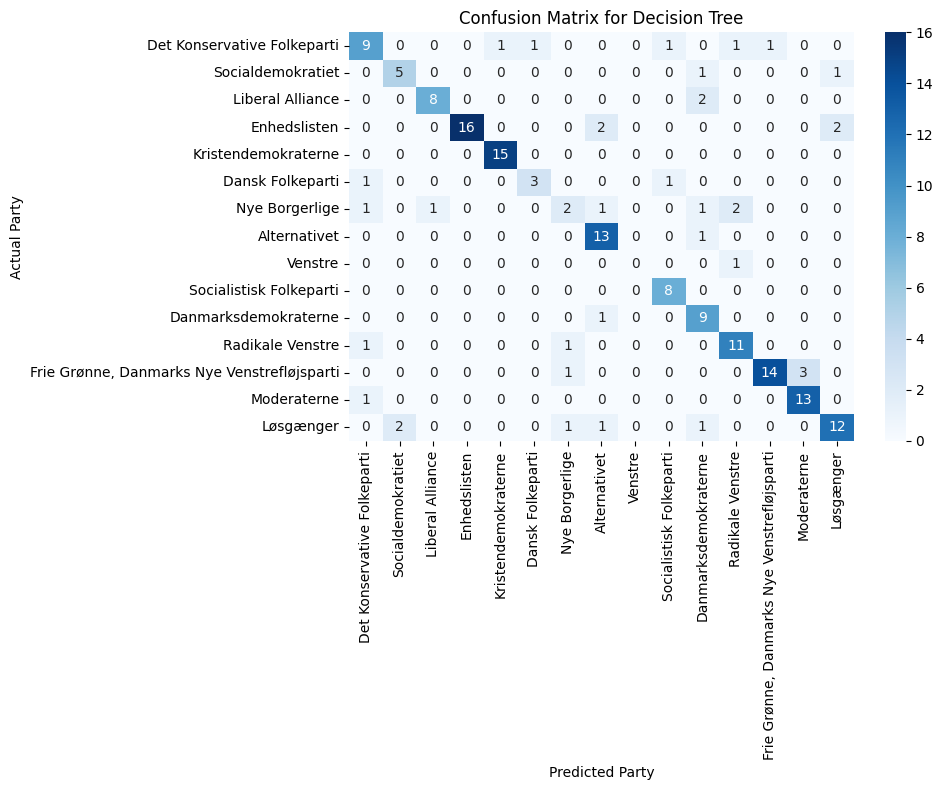

Model: Random Forest


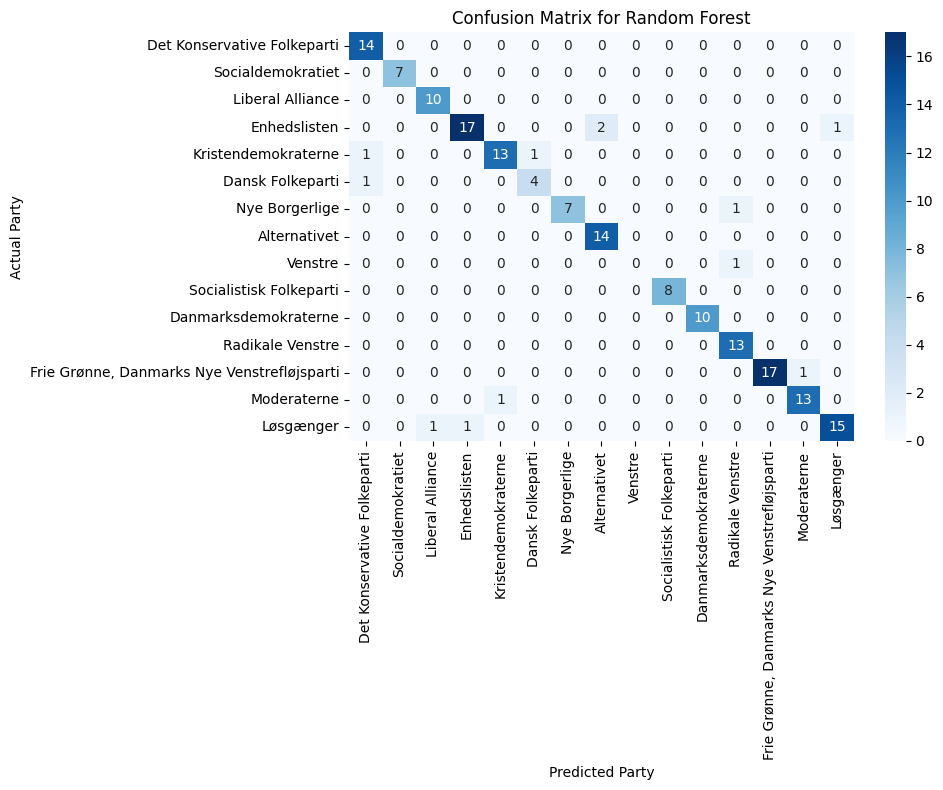

Model: Gradient Boosted Tree


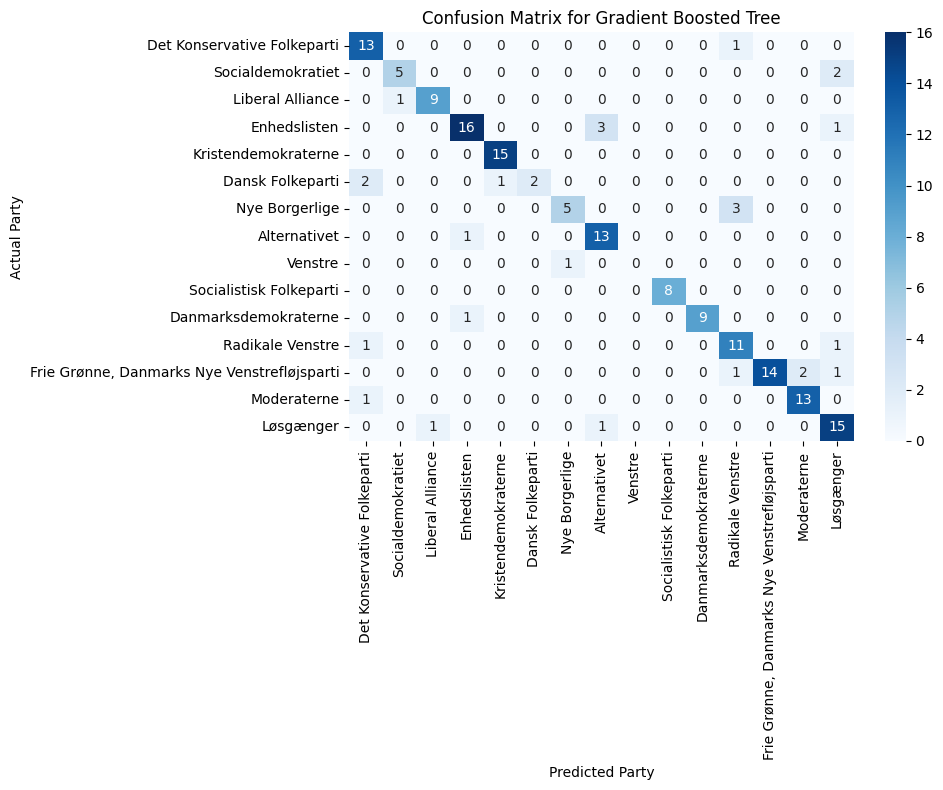

Model: K-Nearest Neighbors


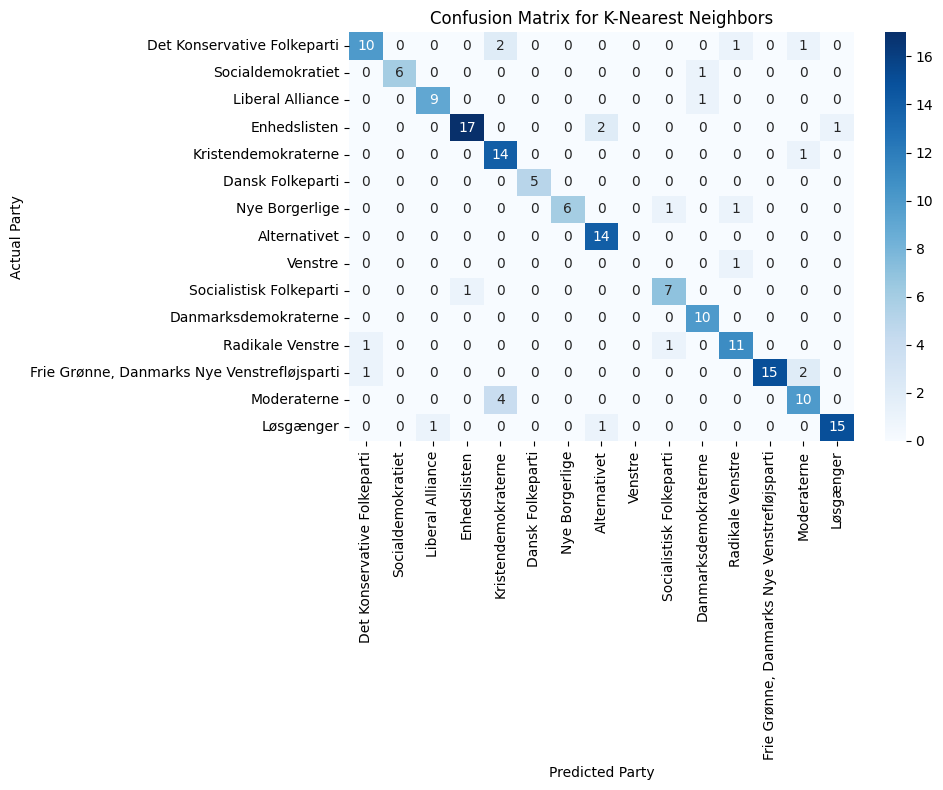

Model: Logistic Regression


C:\Users\Alexander Howson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


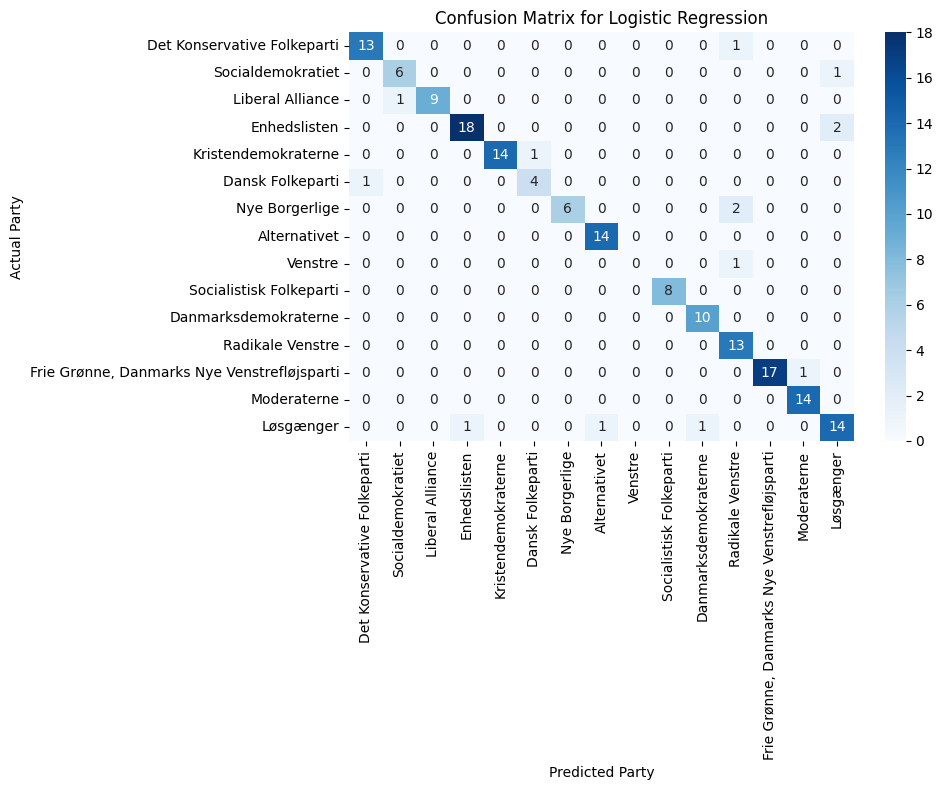

Model: Linear Regression


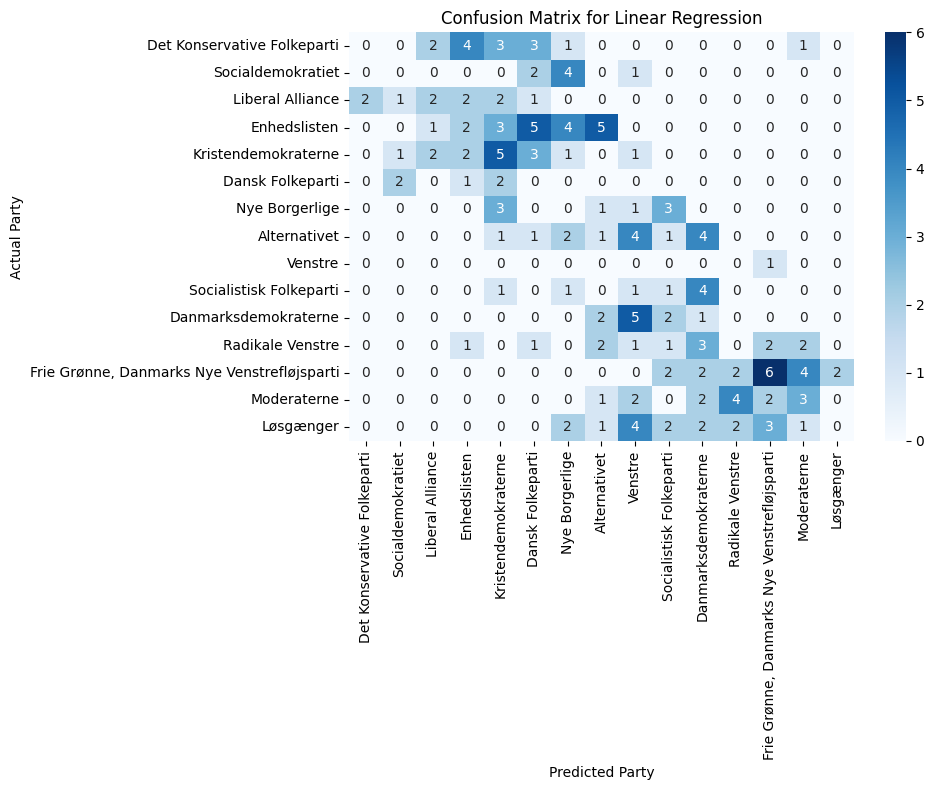

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the range of valid class labels from the encoder
valid_labels = label_encoder.classes_

# Loop over all models
for name, model in models.items():
    print(f"Model: {name}")
    
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    model.fit(X_train_preprocessed, y_train_encoded)
    y_pred = model.predict(X_test_preprocessed)
    
    # The labels to pridect have been converded from there class i.e. parties into numbers like [0, 1, 2...]. And here we make the data fit the classification by using round and clip.
    if name == "Linear Regression":
        y_pred_rounded = np.round(y_pred).astype(int)
        y_pred_rounded = np.clip(y_pred_rounded, 0, len(valid_labels) - 1)
        y_pred_party = valid_labels[y_pred_rounded]
    else:
        y_pred_party = label_encoder.inverse_transform(y_pred)
    y_test_party = label_encoder.inverse_transform(y_test_encoded)

    y_test_party_series = pd.Series(y_test_party)
    y_pred_party_series = pd.Series(y_pred_party)

    cm = confusion_matrix(y_test_party, y_pred_party, labels=valid_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_test_party_series.unique(), yticklabels=y_test_party_series.unique())
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Party")
    plt.ylabel("Actual Party")
    plt.tight_layout()
    plt.show()



We have also tried to use the linear regression for our classification problem.
Linear regression outputs a continuous number that can be anything, making it difficult to set reasonable thresholds, and therefore result in poor class predictions.